# Spike Tutorial -- Part 2

## Analyzing Populations

In part 1 we had to do quite a bit of work to get our data in a workable format. Now that we understand the data structures and how to manipulate them, we can focus more on scientific questions. In this tutorial, the focus will be on analyzing multiple neurons and organizing and analyzing that data. There are many ways to do this in Matlab, and it seems like even more in Python, so we'll explore a few of them.

First import our favorite modules!

In [1]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle


%matplotlib inline

We pickled our session info. from last time, let's load it up:

In [2]:
root = '_data'
fn = os.path.join(root,'sessionInfo.pkl')

with open(fn,'rb') as f:
    [order, clustInfo, fs, stimOn] = pickle.load(f)

Ok, we have almost everything we need except our spikes. Load the `'spike_times.npy'` and `'spike_clusters.npy'` to `spikes` and `clust`, respectively. Convert your spikes to seconds using `fs`.

In [3]:
spikes = np.load(os.path.join(root,'spike_times.npy')) / fs
clust = np.load(os.path.join(root,'spike_clusters.npy'))

We have all of our raw data, lets use what we learned from last time to make PSTHs and rasters for each cell! Because we need to make a PSTH for every neuron, we should write a function to do that. Write a function called `makePSTH` that takes 3 inputs: `spikes`, `triggers`, `edges` and returns `psth`, `raster` and `trials`.

TIP: make the function as general as possible... to compute the firing rate per bin you need to divide by the bin time. Is there a way to do that from just the three variables we've passed?

In [4]:
def makePSTH(spikes,triggers,edges):
    
    # preallocate
    raster = []
    trials = []
    psth = np.empty([len(triggers),len(edges)-1])

    for i,trig in enumerate(triggers):

        # zero spikes
        spks = spikes - trig

        # spike histogram appended to PSTH
        psth[i,:],_ = np.histogram(spks,bins=edges)
        psth[i,:] = psth[i,:] / np.diff(edges).mean()

        # extend raster (using only spikes within each trial range)
        spks = spks[(spks>edges[0]) & (spks<edges[-1])]
        raster.extend(spks)
        trials.extend(np.ones(len(spks))*(i+1))
    
    return [psth,raster,trials]
        

Like last time, lets define `edges` in steps of .001 between -.1 and 3.1s, and then define a vector called `time` with the edge centers. Take some spikes from an unit 26 and use your function to make `psth`, `raster`, and `trials`. Scatter plot the raster to make sure this worked well.

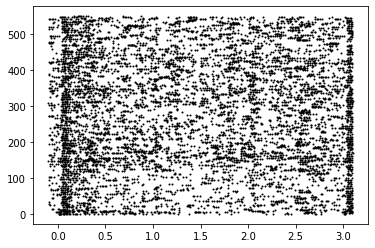

In [5]:
# compute psth, raster
edges = np.arange(-.1,3.1,.001)
time = edges[:-1] + np.diff(edges).mean()/2
psth,raster,trials = makePSTH(spikes[clust==26],stimOn,edges)

# plot
plt.scatter(raster,trials,1,'k')

Next we want to compute PSTHs for all of our neurons and save them to a data struct. There are a lot of ways to do this I think, but the way we can first try is by them in a 3d array (that is, n trials x m timepoints x p neurons).

**Try this:**
1. Make an **array** called `cellID` that contains the unique cell ID numbers for all our our neurons in `clustInfo`.
2. Loop through this variable. On each loop, extract spikes for that cell and use your PSTH function to make a PSTH (don't make raster,trials for now)
3. Save each cell's PSTH to a new matrix called `allPSTH`, like described above. Remember to preallocate this matrix.
4. This might take a little while to run, print the iteration each time the loop runs to keep track of your progress.

In [6]:
cellID = np.asarray(clustInfo.id)
allPSTH = np.empty([len(stimOn),len(edges)-1,len(cellID)])

for i,ID in enumerate(cellID):
    
    cSpks = spikes[clust == ID]
    
    allPSTH[:,:,i],_,_ = makePSTH(cSpks,stimOn,edges)
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


The benefit of putting everything in an array is that we can really easily index and average data using numpy. 

**Try this:**
1. As a first pass, make an index for laser ON/OFF trials.
2. Then index `allPSTH` and average to find the mean response over all neurons when the laser is on vs when it is off. You can save your responses to `meanLaserOff` and `meanLaserOn`. HINT: you need to average over more than 1 dimension!
3. Plot these cell averages on top of each other. Give them a legend and axis labels.

Text(0, 0.5, 'FR (Hz)')

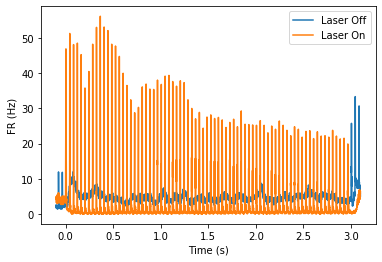

In [9]:
# index and means
I = order[:,1]==1

meanLaserOff = allPSTH[~I,:,:].mean(axis=2).mean(axis=0)
meanLaserOn = allPSTH[I,:,:].mean(axis=2).mean(axis=0)

# plot
plt.plot(time,meanLaserOff)
plt.plot(time,meanLaserOn)
plt.legend(['Laser Off','Laser On'])
plt.xlabel('Time (s)')
plt.ylabel('FR (Hz)')

Woah! It should look pretty funky, with the laserOn plot having very stereotyped bursting activity. This is because the laser was pulsed at 25Hz and it looks like there are some optotagged units in this recording! (that means that the unit will be activated on each laser pulse).

Lets try to separate these units out from the rest.

**Try this:**
1. Compute new averages, averaging over the entire trace on laser off vs laser on trials for each cell. Your ending vectors will be length of the number of neurons, 49. Call them `cellLaserOff` and `cellLaserOn`.
2. Compute a difference vector, subtracting the firing rate when the laser is off from when it is on, call this `dLaser`

In [19]:
# compute the average response difference between laser off and laser on trials for each neuron
cellLaserOff = allPSTH[~I,:,:].mean(axis=0).mean(axis=0)
cellLaserOn = allPSTH[I,:,:].mean(axis=0).mean(axis=0)
dLaser = cellLaserOn - cellLaserOff

Now you can use `dLaser` as an index to separate cells that are activated by the laser vs suppressed by the laser.

1. Make two new PSTHs, one called `supPSTH` which contains neurons that are suppressed by laser, and another called `actPSTH` which contains only activated neurons.
2. Get the population means for laser on and off trials for each of these sets of neurons.
3. On two subplots, plot laser on vs laser off traces for each population. Color the activated subplot in black for laser off and black, dashed lines for on. Do the same for the suppressed neurons subplot, but in blue.

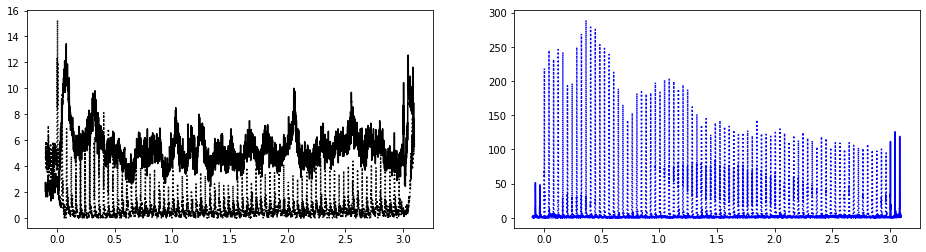

In [22]:
# separate out these cells into new PSTH matrices for optotagged vs suppressed neurons
supPSTH = allPSTH[:,:,dLaser<0]
actPSTH = allPSTH[:,:,dLaser>0]

# get new means and plot
mSupOff = supPSTH[~I,:,:].mean(axis=2).mean(axis=0)
mSupOn = supPSTH[I,:,:].mean(axis=2).mean(axis=0)

mActOff = actPSTH[~I,:,:].mean(axis=2).mean(axis=0)
mActOn = actPSTH[I,:,:].mean(axis=2).mean(axis=0)

fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(time,mSupOff,'k')
ax[0].plot(time,mSupOn,'k:')

ax[1].plot(time,mActOff,'b')
ax[1].plot(time,mActOn,'b:')

In [ ]:
# implement gaussian smoothing